## Import Libraries

The first step is to import external libraries. These libraries will enable us to do complicated data analysis.
You will need to install these libraries inside your python environment beforehand for this to work. Refer to the helper document that we have sent you for more details.

We will be using numpy for storing and manipulating data as arrays, matplotlib for plotting functions, datetime for working with time data, astropy for FITS I/O operations and sunpy for solar specific instrument I/O operations.

In [1]:
import numpy as np
import math
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.dates as plt_dates
import matplotlib.ticker as mticker
from sunpy.time import TimeRange, parse_time
from astropy.time import Time, TimeDelta
import astropy.units as u
from datetime import datetime
from scipy import stats
from functools import partial
from datetime import timedelta 

## Helper Functions

In [2]:
#Func1
def moving_average(arr, w):
    '''
    Compute a moving average.
    
    Parameters:
    ------------
    arr : 'array'
         One-dimensional array on which the moving average needs to be computed
    w : 'int'
         Window-size of the moving average. Should be less than the size of the array.
         
    Returns:
    ----------
    out: 'array'
         The computed array
    
    '''
    return np.convolve(arr, np.ones(w), 'valid') / w


#Func2
def integrate_over_time(arr,integration_time,avg=False):
    '''
    Integrate over time by summing over in chunks of data
    
    Parameters:
    -------------
    arr: 'array'
         One-dimensional array on which the integration needs to be computed
    integration_time: 'int'
         Should be multiples of 4.
         The data would be divided in chunks depending on the number of data points
         and the integration time requested.
         
    Returns:
    ------------
    arr_int: 'array'
         
    '''
    chunk_no = len(arr)//(integration_time/4)
    if avg:
        arr_int = np.array([sum(arr)/len(arr) for arr in np.array_split(arr,chunk_no)])
    else:
        arr_int = np.array([sum(arr) for arr in np.array_split(arr,chunk_no)])
    return arr_int

#Func3
def convert_seconds_datetime(sod_i,date_obs):
    '''
    Convert seconds of day into a datetime object
    
    Parameters:
    ------------
    sod_i:'float'
          A single element of seconds of day. Should be between 0 and 86400.0
    date_obs:'str'
          The date of the observation in YYYY-MM-DD format
    Returns:
    -----------
    out: 'datetime'
    '''
    for fmt in ('%Y-%m-%dT%H:%M:%S.%f', '%Y-%m-%dT%H:%M:%S'):
        try:
            return datetime.strptime(date_obs+'T'+str(timedelta(seconds=sod_i)), fmt)
        except:
            pass

## RHESSI Data

The Reuven Ramaty High Energy Solar Spectroscopic Imager (RHESSI) was a NASA Small Explorer Mission, launched on February 5, 2002. The primary mission of RHESSI was to explore how particle energization happened during the explosive energy release associated with a solar flare. This was achieved through state-of-the art imaging spectroscopy in X-rays and gamma-rays with fine angular and energy resolution. This enabled the study of flare locations and the spectra of accelerated electrons and ions of the hottest plasma.

After 16 years of successful operation, RHESSI was finally decommissioned on August 16,2018. During its lifetime, RHESSI observed more than 120000 X-ray events, providing us with a wealth of data to understand and analyse. 

In this section, you will start with the basic I/O operations from the RHESSI.
                                    

We are interested in RHESSI Quicklook information. The Observing Summary is obtained directly from the telemetry packets. The photons are time-binned and the count rate is compressed to bytes (0.03 accuracy up to 1.0e6 counts/sec). Aspect solution, pointing, roll angle and roll period are given also. The nominal interval time for the count rates is the spin period of the spacecraft, 4 seconds, ephemeris info is given every 20 seconds , aspect info is given every second, roll period is given every 20 seconds.

As you can see, the quicklook file contains plenty of information which are all not needed for plotting a lightcurve. Hence we have created an easy to operate file for you. 

In [3]:
#task 1
def parse_rhessi_fits(fits_filename):
    '''
    This function will allow you to open a RHESSI fits file,
    read and retrieve data, and then store it inside a dictionary.
    
    You've to pass this dictionary and the primary HEADER back for 
    further processing.
    The structure of fits file is as follows
    0 - Counts
    1 - Flags
    '''
    
    hdul = fits.open(fits_filename)
    header = hdul[0].header  #complete this code(1 line)
    
    Counts = hdul[0].data                     #complete this code(1 line)
    Flags =  hdul[1].data                  #complete this code(1 line)
    
    labels = ['3 - 6 keV', '6 - 12 keV', '12 - 25 keV', '25 - 50 keV',
              '50 - 100 keV', '100 - 300 keV', '300 - 800 keV',
              '800 - 7000 keV', '7000 - 20000 keV']
    
    data = {'data': Counts, 'labels': labels,'flags':Flags}
    
    return header,data

In [4]:
rhessi_header,rhessi_data = parse_rhessi_fits("flares_stix&rhessi/20120908_rhessi.fits")         #call the function by passing the filename
print(rhessi_header)
print(rhessi_data['data'].shape)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                   64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                    9                                                  NAXIS2  =                21600                                                  EXTEND  =                    T                                                  DATE    = '2019-11-15'         /                                                ORIGIN  = 'max     '           / Usually the CPU used to generate the file      OBSERVER= 'hessiops'           / Usually the name of the user who generated the TELESCOP= 'HESSI   '           / The High Energy Solar Spectroscopic Imager     OBJECT  = 'Sun     '           /                                                DATE_OBS= '2012-08-09T00:00:00.000' /                                           DATE_END= '2012-08-10T00:00:00.000' /   

As you may have noticed the time information is not passed down. Thus we need to create an array to plot the data
accurately. We will create a time array from the information we obtained from the header. 
We need two quantities here, the date of the observation 'DATE_OBS' and the size of the time axis 'NAXIS2'.

In [5]:
# you need to fill in the appropriate quantities from the header
# to get a time array. Please note you need to remove the strings.
# They are there only as a guide.
# The time array we are creating are for the whole duration of the observation time
# mentioned in the HEADER. Later we will slice this file to collect data
# for the flare we are interested in

time_array = parse_time(rhessi_header['DATE_OBS']) + \
        TimeDelta(4.0 * np.arange(rhessi_header['NAXIS2']) * u.second)

In [6]:
# Now that you've the time array, add that to the 'rhessi_data' dictionary
# under the key name 'time'
rhessi_data["time"] = time_array                                                           #complete this code(1 line)

In [7]:
# execute this line to convert the timearray we created into datetime format
hxr_time = rhessi_data['time'].datetime

In [8]:
print(hxr_time)

[datetime.datetime(2012, 8, 9, 0, 0)
 datetime.datetime(2012, 8, 9, 0, 0, 4)
 datetime.datetime(2012, 8, 9, 0, 0, 8) ...
 datetime.datetime(2012, 8, 9, 23, 59, 48)
 datetime.datetime(2012, 8, 9, 23, 59, 52)
 datetime.datetime(2012, 8, 9, 23, 59, 56)]


In [9]:
# we are defining the flare time here 
# you don't need to implement anything here
date_ = [9,8,2012]
timerange_st = [9,13,0]
timerange_end = [9,25,0]

time_param = {}
time_param['date start'] = date_
time_param['date end'] = date_
time_param['time start'] = timerange_st
time_param['time end'] = timerange_end

In [10]:
# Read the time parameters into individual variables 
# for day, hour,min and seconds for accurate slicing of the time axis.
# For examples here start date and end date are the same. However
# we pass two seperate variables for generalisation purposes

dd_st,mm_st,yyyy_st =  time_param["date start"]                        #complete this code
hh_st,MM_st,ss_st =  time_param["time start"]            #complete this code
dd_en,mm_en,yyyy_en = time_param["date end"]                          #complete this code
hh_en,MM_en,ss_en = time_param["time end"]                             #complete this code

In [11]:
# Now you need to slice the time axis. We do this by checking
# the array indices of the time points within the defined time above.
# We will pass these indices for collecting data only within the 
# defined time interval.

# you need to pass a datetime object in the place of the two strings added here
# the datetime object is in the form:
# datetime(yyyy, mm, dd,hh,MM,ss)

hxr_idx = np.where((hxr_time >= datetime(yyyy_st,mm_st,dd_st,hh_st,MM_st,ss_st) ) &        #enter your code after removing the string
                          (hxr_time <= datetime(yyyy_en,mm_en,dd_en,hh_en,MM_en,ss_en)))[0]  #enter your code after removing the string

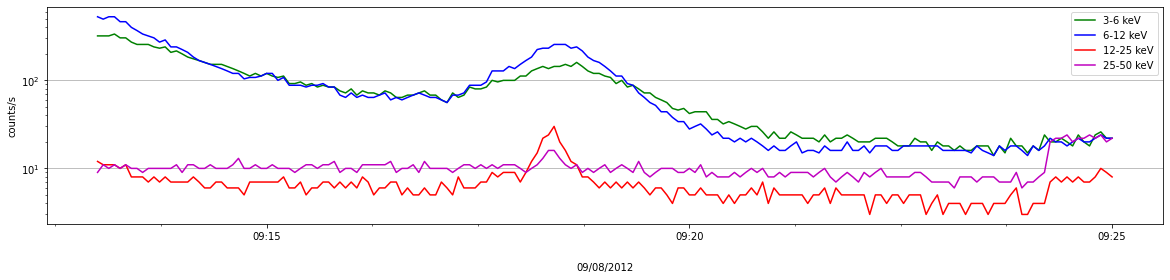

In [12]:
# We will now plot and see the flare that we are interested in
# You need to complete the code by passing an axis object 
# and the data along with hxr_idx that we calculated above.
# We will be using plot_date instead of plot, because the x-axis is time
# The code that you need to write should be in the following format.
# axis_obj.plot_date(hxr_dates[idx],rhessi_data['data'][idx,chan 1].ravel(),'-')

fig = plt.figure(figsize=(20,4),facecolor='w')
axes = fig.subplots(nrows=1,ncols=1,)                      #axis object
hxr_dates = plt_dates.date2num(hxr_time)

l1, = axes.plot_date(hxr_dates[hxr_idx],rhessi_data['data'][hxr_idx,0].ravel(),'g')  #your code here  (chan 1)
l2, = axes.plot_date(hxr_dates[hxr_idx],rhessi_data['data'][hxr_idx,1].ravel(),'b')                                       #your code here  (chan 2)
l3, = axes.plot_date(hxr_dates[hxr_idx],rhessi_data['data'][hxr_idx,2].ravel(),'r')                                       #your code here  (chan 3)
l4, = axes.plot_date(hxr_dates[hxr_idx],rhessi_data['data'][hxr_idx,3].ravel(),'m')                                       #your code here  (chan 4)
axes.legend((l1,l2,l3,l4), ('3-6 keV', '6-12 keV','12-25 keV','25-50 keV'),
                             loc='upper right')
#l5 = axes.plot_date(hxr_dates[atten1],np.ones_like(hxr_dates[atten1])*hxrCounts[hxr_idx,:].max()*1.05,'r')
axes.minorticks_on()
axes.yaxis.set_minor_locator(mticker.MultipleLocator(5))
axes.set_yscale("log")
axes.set_ylabel('counts/s')
axes.yaxis.grid(True, 'major')
date_format = plt_dates.DateFormatter('%H:%M')
axes.xaxis.set_major_formatter(date_format)
axes.text(0.5, -0.2, datetime.date(hxr_time[0]).strftime("%d/%m/%Y"), ha='center', va='center',
         transform=axes.transAxes)
plt.show()

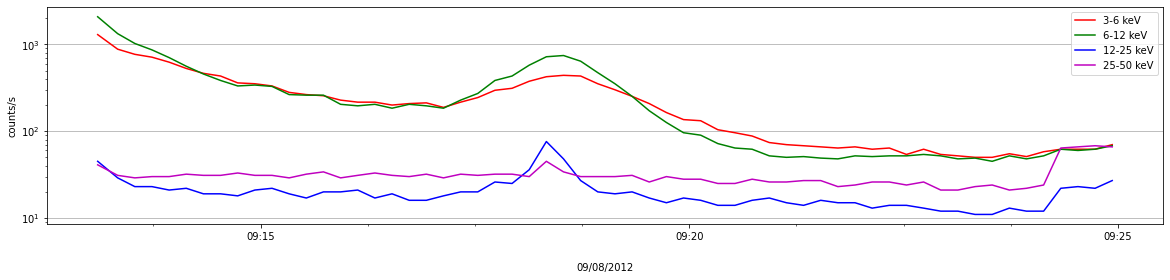

In [13]:
# We will now integrate the data over time and see how the data changes 
# as a function of the time interval chosen.
# The function that will help you to integrate is already given to you 
# in the helper section.

int_time =  12                             # choose a multiple of 4

#We are integrating the time axis here. Pass in the quantities
hxr_dates_int = integrate_over_time( hxr_dates[hxr_idx],int_time  ,avg=True)       

# Now we will integrate the counts.
# To make the process efficient we are using a special function called apply_along_axis
# You can pass in the whole count array within the time we are interested in.

hxr_counts_int = np.apply_along_axis(integrate_over_time, 0, 
                                      rhessi_data['data'][hxr_idx,:],integration_time=int_time)
fig = plt.figure(figsize=(20,4),facecolor='w')
axes = fig.subplots(nrows=1,ncols=1,)
hxr_dates = plt_dates.date2num(hxr_time)

#complete the followin code to plot it
# Similar to the first plot, you need to pass the 
# axes object and the data for x and y axis.
l1,= axes.plot_date(hxr_dates_int,hxr_counts_int[:,0],'r')
l2,= axes.plot_date(hxr_dates_int,hxr_counts_int[:,1],'g')
l3,= axes.plot_date(hxr_dates_int,hxr_counts_int[:,2],'b')
l4,=axes.plot_date(hxr_dates_int,hxr_counts_int[:,3],'m')
axes.legend((l1,l2,l3,l4), ('3-6 keV', '6-12 keV','12-25 keV','25-50 keV'),
                             loc='upper right')
#l5 = axes.plot_date(hxr_dates[atten1],np.ones_like(hxr_dates[atten1])*hxrCounts[hxr_idx,:].max()*1.05,'r')
axes.minorticks_on()
axes.yaxis.set_minor_locator(mticker.MultipleLocator(5))
axes.set_yscale("log")
axes.set_ylabel('counts/s')
axes.yaxis.grid(True, 'major')
date_format = plt_dates.DateFormatter('%H:%M')
axes.xaxis.set_major_formatter(date_format)
axes.text(0.5, -0.2, datetime.date(hxr_time[0]).strftime("%d/%m/%Y"), ha='center', va='center',
         transform=axes.transAxes)
plt.show()

In [14]:
# Modify this function to get the Poisson statistics
def Poissonsignaltonoise(signal,axis=0):
    noise= 1/np.sqrt(len(signal))                      # complete the code to get noise. You will have to use numpy sqrt function
    signaltonoise=signal/noise
    return signaltonoise

In [19]:
#Now experiment with different integration times and how this is affecting 
#Poisson statistics
int_time =   8                              # choose a multiple of 4

#We are integrating the time axis here. Pass in the quantities 
hxr_dates_int = integrate_over_time(   hxr_dates[hxr_idx],  int_time ,avg=True)       

# Now we will integrate the counts.
# To make the process efficient we are using a special function called apply_along_axis
# You can pass in the whole count array within the time we are interested in.

hxr_counts_int = np.apply_along_axis(integrate_over_time, 0, 
                                      'whole count array within hxr idx ',integration_time='integration time  ')

fig = plt.figure(figsize=(9,3),facecolor='w')
axes = fig.subplots(nrows=1,ncols=1,)
hxr_dates = plt_dates.date2num(hxr_time)
#fill in the rest of the code to plot poisson statistics of the light curve
# you can copy the code from the previous plots



AxisError: axis 0 is out of bounds for array of dimension 0

## STIX Data

STIX is the modern day replacement of RHESSI. STIX is one of the instrument onboard Solar Orbiter which was launched on February 10,2020. Solar Orbiter will get as close as 60 solar radii from the Sun. This will give unprecedented opportunities to observe the Sun in multiple wavelengths up close. The design philosophy of STIX is very similar to that of RHESSI, however the implementation is very different owing to advancements in technology and the need to have extremely low rates of telemetry. 

In this exercise, you will open a STIX quick look fits file to plot the light curves similar to RHESSI. However, we will be using the original data file obtained from STIX without any modification. For RHESSI, we avoided using the original file for ease of use. STIX file on the contrary is already condensed and contains much less information to unpack compared to RHESSI.

In [ ]:
#We highly recommend you to run the following code to get an understanding 
#of the structure of STIX data file given to you.
# The data is stored in a TABLE format at position 3 (hdulist[2])
# We need the 'time' and 'counts' column from this table,
# which you will implement in the function below

hdulist = fits.open('STIX file name')
hdulist[2].columns

In [ ]:
def parse_stix_ql(fits_filename):
    '''
    Implement this function to read a STIX fits file
    You need to return from this function the header and the data in a dictionary format
    
    To read the time and counts you need to remember the position at which they are stored.
    To read a column from a table in a FITS file you need to use the command 
    hdulist[table_position].data.field('column_name')
    You need to find the table_position and 'column_name'
    Please note table_position is int and 'column_name' is str
    '''
    hdulist = fits.open(fits_filename)
    header =                                 #your code here(1 line)
    time_sod =                               #your code here(1 line)(put the 'time' field here)
    counts =                                 #your code here(1 line)(put the 'counts' field here)
    labels = [str(x)+'-'+str(y)+' keV' for x,y in zip(hdulist[3].data['e_low'],hdulist[3].data['e_high'])]
    
    data = {'time':time_sod,'data':counts,'labels':labels}
    return header,data

In [ ]:
stix_header,stix_data = parse_stix_ql()         #call the function by passing the filename

print(stix_header)

In [ ]:
# unlike RHESSI we get the time information from the fits file itself
# for STIX. However it is in seconds of day format. 
# We will now convert it into datetime format similar to RHESSI
# For date_obs_str you need to pass the 'DATE_AVG' entry from the header file.

date_obs_str = 
map_func = partial(convert_seconds_datetime,
                    date_obs=date_obs_str.split('T')[0])
time_arr = np.asarray(list(map(map_func,'Enter time array from STIX ')))   #pass in time array from stix_data
                                                                           #You've to complete the code by replacing
                                                                           #the string

In [ ]:
# Now that you've the time array, replace the time in 'stix_data' dictionary
# under the key name 'time'
                                                           #complete this code(1 line)

In [ ]:
# We are defining the time here
# You don't need to add anything here
date_ = [7,5,2021]
timerange_st = [18,40,0]
timerange_end = [19,30,0]

time_param = {}
time_param['date start'] = date_
time_param['date end'] = date_
time_param['time start'] = timerange_st
time_param['time end'] = timerange_end

In [ ]:
# First assign the date time variables similar to what you have done for RHESSI

# As before you need to slice the time axis. We do this by checking
# the array indices of the time points within the defined time above.
# We will pass these indices for collecting data only within the 
# defined time interval.

# you need to pass a datetime object in the place of the two strings added here
# the datetime object is in the form:
# datetime(yyyy, mm, dd,hh,MM,ss)

dd_st,mm_st,yyyy_st =   #your code here 
hh_st,MM_st,ss_st =     #your code here 
dd_en,mm_en,yyyy_en =   #your code here 
hh_en,MM_en,ss_en =     #your code here 
hxr_idx = np.where((stix_data['time'] >= 'your code ') &                          # pass in the datetime objects
                          (stix_data['time'] <= 'your code '))[0]                 # refer to what you've done in the case
                                                                         # of RHESSI. Enter your code by replacing the 
                                                                         # strings

In [ ]:
#now plot the data. Follow the same format as you did for RHESSI
fig = plt.figure(figsize=(9,3),facecolor='w')
axes = fig.subplots(nrows=1,ncols=1,)
hxr_dates = plt_dates.date2num(stix_data['time'])
l1, =                                                     #your code here
l2, =                                                     #your code here
l3, =                                                     #your code here
l4, =                                                     #your code here
axes.legend((l1,l2,l3,l4), ('4-10 keV', '10-15 keV','15-25 keV','25-50 keV'),
                             loc='upper right')
l5 = axes.plot_date(hxr_dates[atten1],np.ones_like(hxr_dates[atten1])*hxrCounts[hxr_idx,:].max()*1.05,'r')
axes.minorticks_on()
axes.yaxis.set_minor_locator(mticker.MultipleLocator(5))
axes.set_yscale("log")
axes.set_ylabel('counts')
axes.yaxis.grid(True, 'major')
date_format = plt_dates.DateFormatter('%H:%M')
axes.xaxis.set_major_formatter(date_format)
axes.text(0.5, -0.2, datetime.date(stix_data['time'][0]).strftime("%d/%m/%Y"), ha='center', va='center',
         transform=axes.transAxes)
plt.show()